# **Code Tugas Besar Kelompok 04 : Clustering DBSCAN Kepadatan Penduduk Kabupaten Muara Enim Sumatera Selatan**
---
> Kelompok 4 : \
> Anasthashya Rachman (121450013) \
> Balqis Dwian Fitri Zamzami (121450018) \
> Ghozi Alvin Karim (121450123) \
> Rafi Fadhlillah (121450143) \
> Khalda Luthfi A. (121450160)
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [2]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import great_circle
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Membaca Data

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


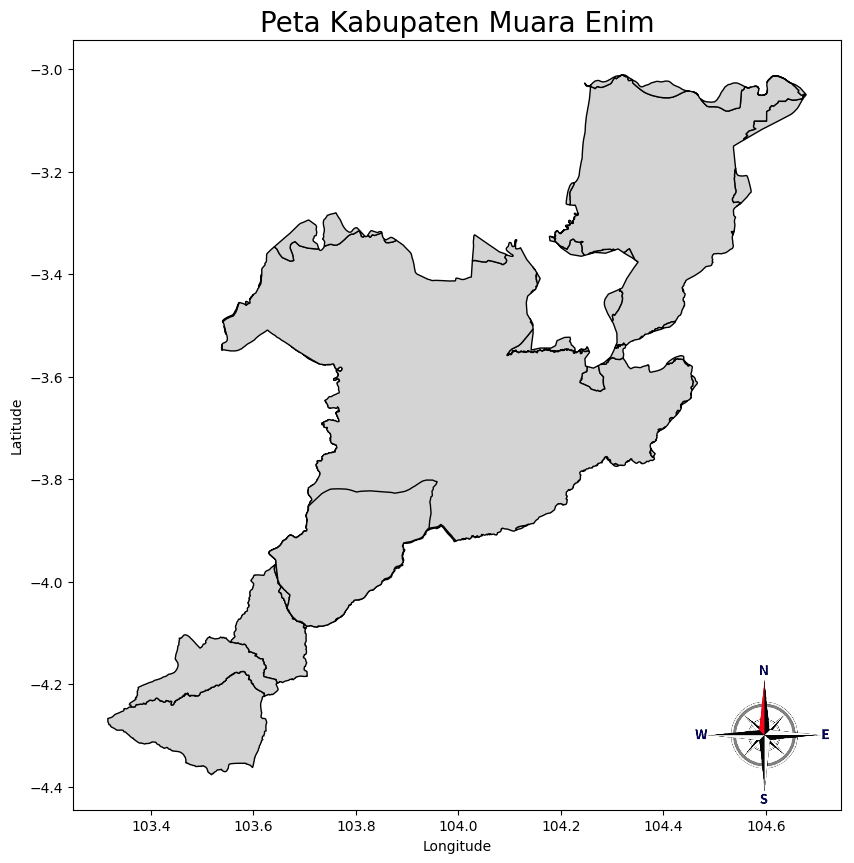

In [7]:
# Baca shapefile
shapefile = '/content/drive/MyDrive/ADSP/Tubes/MuaraEnim.shp'
gdf_boundary = gpd.read_file(shapefile)

# Baca data kepadatan penduduk dari file CSV
file_csv = '/content/drive/MyDrive/ADSP/Tubes/PendudukMuaraEnim.csv'  # Ganti dengan path file CSV Anda
df_population_density = pd.read_csv(file_csv)

# Perbaiki format koordinat yang menggunakan tanda koma
df_population_density['Latitude'] = df_population_density['Latitude'].str.replace(',', '.').astype(float)
df_population_density['Longitude'] = df_population_density['Longitude'].str.replace(',', '.').astype(float)

# Konversi data CSV ke dalam bentuk geometri titik
geometry = [Point(xy) for xy in zip(df_population_density['Longitude'], df_population_density['Latitude'])]
crs = {'init': 'epsg:4326'}  # WGS84
gdf_population_density = gpd.GeoDataFrame(df_population_density, crs=crs, geometry=geometry)

# Fungsi untuk menambahkan gambar
def add_image(ax, image_path, zoom=1, x=0.9, y=0.9):
    img = plt.imread(image_path)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (x, y), frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

# Visualisasi batas administrasi
fig, ax = plt.subplots(figsize=(10, 10))
gdf_boundary.plot(ax=ax, color='#D4D4D4', edgecolor='black')

# Menambahkan gambar kompas
compass_image_path = '/content/drive/MyDrive/ADSP/Tubes/compass.png'  # Ganti dengan path gambar kompas Anda
add_image(ax, compass_image_path, zoom=0.3, x=0.9, y=0.1)

plt.title('Peta Kabupaten Muara Enim', fontsize=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [8]:
df_population_density.head()

,Kecamatan,Latitude,Longitude,Kepadatan_Penduduk
0,Semende Darat Laut,-4.119581,103.614979,57.02
1,Semende Darat Ulu,-4.191228,103.549187,42.67
2,Semende Darat Tengah,-4.167890,103.581329,37.84
3,Tanjung Agung,-4.007918,103.798053,57.78
4,Panang Enim,-4.006565,103.825377,69.14


# **Clustering Menggunakan DBSCAN**
## Mencari Parameter Terbaik

In [9]:
import numpy as np

# Parameters
eps_values = np.arange(0.1, 1.0, 0.01).tolist()  # Membuat array nilai dari 0.1 hingga 0.99 dengan interval 0.01
min_samples_values = [2, 3, 4, 5, 6, 7, 8, 9]

results = []

# Loop through combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(gdf_population_density[['Longitude', 'Latitude']])

        # Calculate metrics
        if len(set(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(gdf_population_density[['Longitude', 'Latitude']], cluster_labels)
            davies_bouldin = davies_bouldin_score(gdf_population_density[['Longitude', 'Latitude']], cluster_labels)
        else:
            silhouette_avg = np.nan
            davies_bouldin = np.nan

        # Append results
        results.append({
            'Eps': eps,
            'MinPts': min_samples,
            'Silhouette Score': silhouette_avg,
            'Davies-Bouldin Index': davies_bouldin
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

print(results_df)


      Eps  MinPts  Silhouette Score  Davies-Bouldin Index
0    0.10       2          0.116314              1.086317
1    0.10       3          0.413913              0.457807
2    0.10       4               NaN                   NaN
3    0.10       5               NaN                   NaN
4    0.10       6               NaN                   NaN
..    ...     ...               ...                   ...
715  0.99       5               NaN                   NaN
716  0.99       6               NaN                   NaN
717  0.99       7               NaN                   NaN
718  0.99       8               NaN                   NaN
719  0.99       9               NaN                   NaN

[720 rows x 4 columns]


## Sort Parameter Terbaik Berdasarkan Silhouette Score

In [10]:
# Drop rows with NaN values
results_df.dropna(inplace=True)

# Sort DataFrame by Silhouette Score in descending order
results_df = results_df.sort_values(by='Silhouette Score', ascending=False)

# Print sorted DataFrame
results_df


,Eps,MinPts,Silhouette Score,Davies-Bouldin Index
107,0.23,5,0.475289,0.634530
115,0.24,5,0.475289,0.634530
123,0.25,5,0.475289,0.634530
114,0.24,4,0.461427,0.668571
124,0.25,6,0.461427,0.668571
...,...,...,...,...
0,0.10,2,0.116314,1.086317
108,0.23,6,0.069042,4.252591
174,0.31,8,0.062274,3.531670
9,0.11,3,0.030620,1.679984


Hasil : epsilon = 0,23 dan min_samples = 5 adalah yang terbaik, parameter ini yang akan digunakan untuk parameter DBSCAN dibawah

## epsilon 0,23 ini dalam apa? berapa jaraknya?

In [ ]:
import math

# Membuat DataFrame
df = pd.DataFrame(df_population_density)

# Menghitung rata-rata garis lintang
average_latitude = df["Latitude"].mean()

# Menghitung jarak per derajat bujur pada rata-rata garis lintang
km_per_degree_longitude = 111.32 * math.cos(math.radians(average_latitude))

# Menghitung epsilon dalam kilometer
epsilon_degrees = 0.23
epsilon_km = km_per_degree_longitude * epsilon_degrees

average_latitude, km_per_degree_longitude, epsilon_km

(-3.622928663636364, 111.09752931351932, 25.552431742109444)

**epsilon = 0,23 sama dengan 25.552431742109444 km**

## DBSCAN epsilon = 0,23 dan min_samples = 5

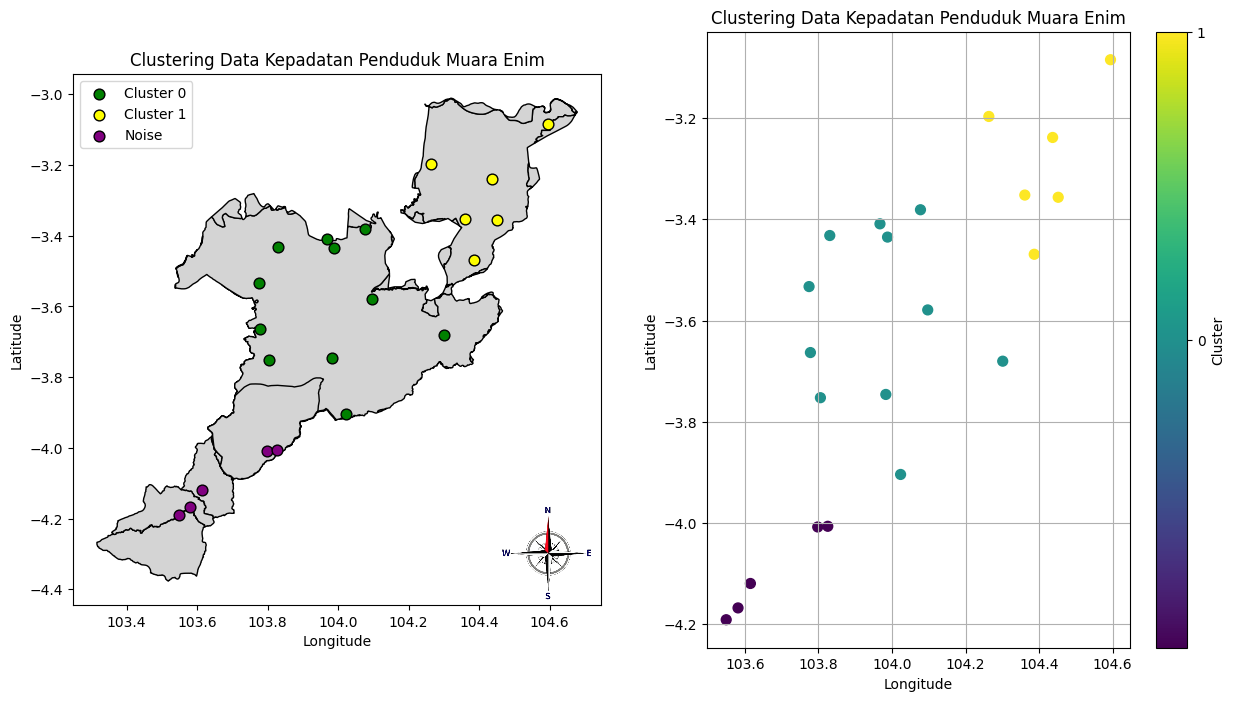

               Kecamatan    Cluster
0           Belida Darat  Cluster 1
1              Belimbing  Cluster 0
2                Benakat  Cluster 0
3   Empat Petulai Dangku  Cluster 0
4              Gelumbang  Cluster 1
5          Gunung Megang  Cluster 0
6                Kelekar  Cluster 1
7           Lawang Kidul  Cluster 0
8                 Lembak  Cluster 1
9                  Lubai  Cluster 0
10             Lubai Ulu  Cluster 0
11          Muara Belida  Cluster 1
12            Muara Enim  Cluster 0
13           Panang Enim      Noise
14               Rambang  Cluster 0
15          Rambang Niru  Cluster 0
16    Semende Darat Laut      Noise
17  Semende Darat Tengah      Noise
18     Semende Darat Ulu      Noise
19          Sungai Rotan  Cluster 1
20         Tanjung Agung      Noise
21              Ujan Mas  Cluster 0


In [ ]:
# Parameter DBSCAN
epsilon = 0.23
min_samples = 5
dbscan_cluster = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean').fit(gdf_population_density[['Longitude', 'Latitude']])

# Dapatkan label cluster
cluster_labels = dbscan_cluster.labels_

# Tentukan tiga kategori berdasarkan label cluster
binary_labels = ['Noise' if label == -1 else ('Cluster 0' if label == 0 else 'Cluster 1') for label in cluster_labels]

# Tambahkan kolom binary_labels ke dalam DataFrame
gdf_population_density['Ternary_Labels'] = binary_labels

# Fungsi untuk menambahkan gambar kompas
def add_image(ax, image_path, zoom=1, x=0.9, y=0.9):
    img = plt.imread(image_path)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (x, y), frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

# Plot untuk visualisasi clustering
plt.figure(figsize=(15, 8))

# Plot peta dengan clustering
ax = plt.subplot(121)
gdf_boundary.plot(ax=ax, color='#D4D4D4',  edgecolor='black')
for category, group in gdf_population_density.groupby('Ternary_Labels'):
    group.plot(ax=ax, color='yellow' if category == 'Cluster 1' else ('green' if category == 'Cluster 0' else 'purple'), markersize=60, edgecolor='black', linewidth = 1, label=category)

# Menambahkan gambar kompas pada plot peta
compass_image_path = '/content/drive/MyDrive/ADSP/Tubes/compass.png'
add_image(ax, compass_image_path, zoom=0.2, x=0.9, y=0.1)

plt.title('Clustering Data Kepadatan Penduduk Muara Enim')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Plot clustering secara terpisah
plt.subplot(122)
plt.scatter(gdf_population_density['Longitude'], gdf_population_density['Latitude'], c=cluster_labels, cmap='viridis', s=50)
plt.title('Clustering Data Kepadatan Penduduk Muara Enim')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster', ticks=range(len(set(cluster_labels))))  # Synchronize the color bar with cluster labels
plt.grid(True)

plt.show()

# Mengelompokkan data berdasarkan kecamatan dan label cluster
cluster_results = gdf_population_density.groupby(['Kecamatan', 'Ternary_Labels']).size().reset_index(name='Count')

# Membuat DataFrame dari hasil cluster
cluster_df = pd.DataFrame({
    'Kecamatan': cluster_results['Kecamatan'],
    'Cluster': cluster_results['Ternary_Labels'],
})

# Menampilkan DataFrame
print(cluster_df)

## Menampilkan Label Kecamatan

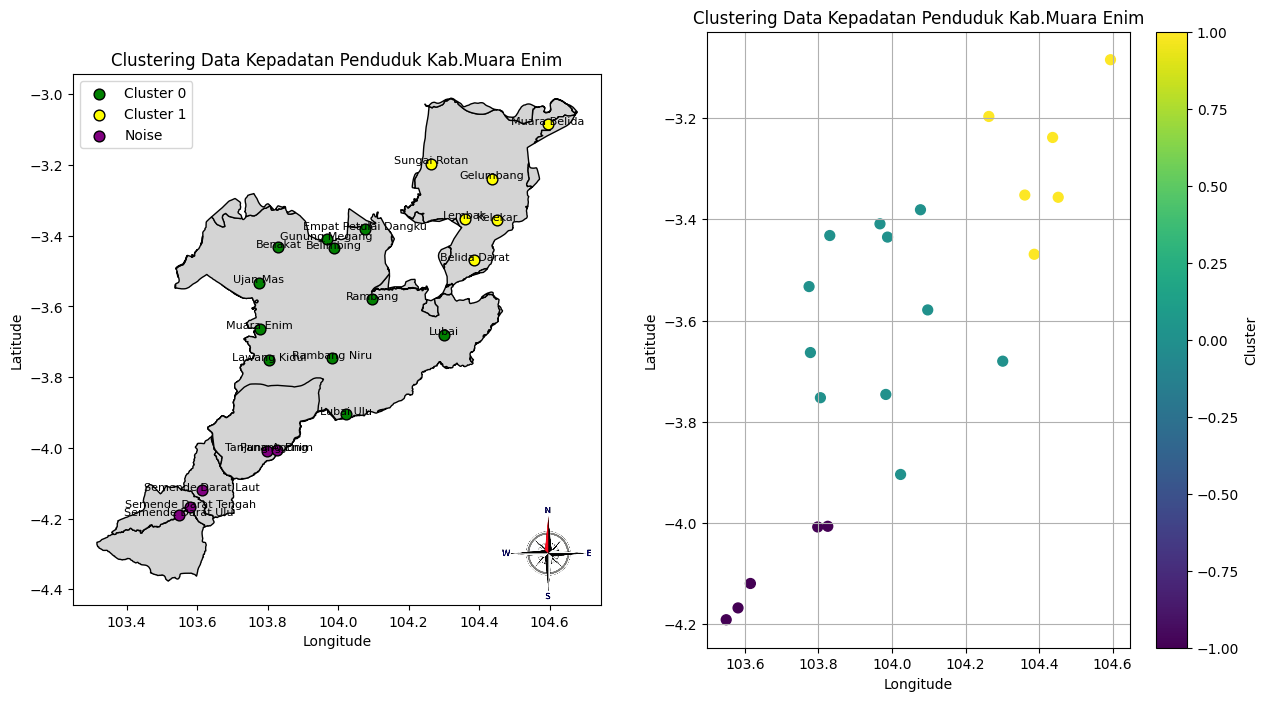

               Kecamatan    Cluster
0           Belida Darat  Cluster 1
1              Belimbing  Cluster 0
2                Benakat  Cluster 0
3   Empat Petulai Dangku  Cluster 0
4              Gelumbang  Cluster 1
5          Gunung Megang  Cluster 0
6                Kelekar  Cluster 1
7           Lawang Kidul  Cluster 0
8                 Lembak  Cluster 1
9                  Lubai  Cluster 0
10             Lubai Ulu  Cluster 0
11          Muara Belida  Cluster 1
12            Muara Enim  Cluster 0
13           Panang Enim      Noise
14               Rambang  Cluster 0
15          Rambang Niru  Cluster 0
16    Semende Darat Laut      Noise
17  Semende Darat Tengah      Noise
18     Semende Darat Ulu      Noise
19          Sungai Rotan  Cluster 1
20         Tanjung Agung      Noise
21              Ujan Mas  Cluster 0


In [ ]:
# Plot untuk visualisasi clustering
plt.figure(figsize=(15, 8))

# Plot peta dengan clustering
ax = plt.subplot(121)
gdf_boundary.plot(ax=ax, color='#D4D4D4',  edgecolor='black')
for category, group in gdf_population_density.groupby('Ternary_Labels'):
    group.plot(ax=ax, color='yellow' if category == 'Cluster 1' else ('green' if category == 'Cluster 0' else 'purple'), markersize=60, edgecolor='black', linewidth = 1, label=category)

# Menambahkan gambar kompas pada plot peta
compass_image_path = '/content/drive/MyDrive/ADSP/Tubes/compass.png'
add_image(ax, compass_image_path, zoom=0.2, x=0.9, y=0.1)

plt.title('Clustering Data Kepadatan Penduduk Kab.Muara Enim', fontsize = 12)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Tambahkan label kecamatan dari data CSV
for idx, row in df_population_density.iterrows():
    plt.text(row['Longitude'], row['Latitude'], row['Kecamatan'], fontsize=8, ha='center',  zorder=3)

# Plot clustering
plt.subplot(122)
plt.scatter(gdf_population_density['Longitude'], gdf_population_density['Latitude'], c=cluster_labels, cmap='viridis', s=50)
plt.title('Clustering Data Kepadatan Penduduk Kab.Muara Enim', fontsize = 12)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)

plt.show()

# Mengelompokkan data berdasarkan kecamatan dan label cluster
cluster_results = gdf_population_density.groupby(['Kecamatan', 'Ternary_Labels']).size().reset_index(name='Count')

# Membuat DataFrame dari hasil cluster
cluster_df = pd.DataFrame({
    'Kecamatan': cluster_results['Kecamatan'],
    'Cluster': cluster_results['Ternary_Labels'],
})

# Menampilkan DataFrame
print(cluster_df)

## Hitung Rataan Kependudukan setiap Cluster Untuk Mendefinisikan Cluster

Rata-rata kepadatan penduduk untuk Cluster 1: 93.18333333333334
Rata-rata kepadatan penduduk untuk Cluster 0 : 132.69818181818184
Rata-rata kepadatan penduduk untuk kecamatan noise: 52.89


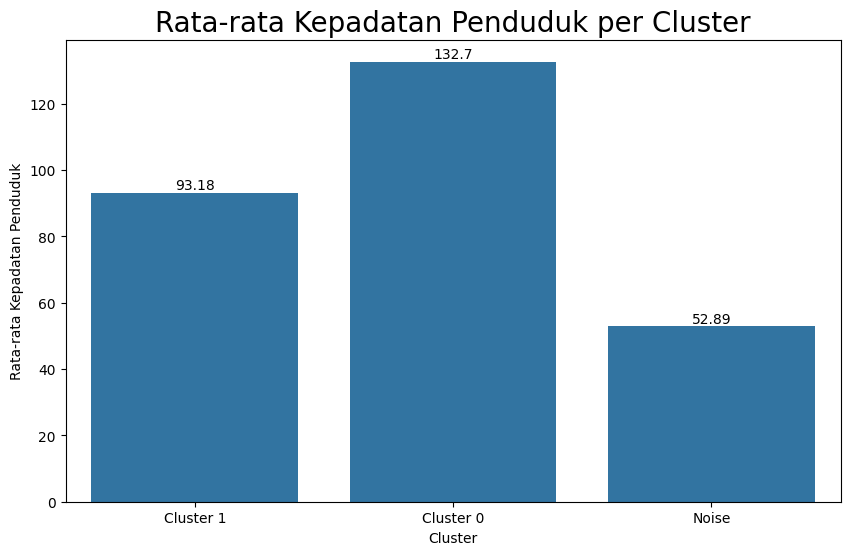

In [ ]:
# Daftar kecamatan yang diinginkan
kecamatan_tertentu = ['Gelumbang', 'Lembak', 'Sungai Rotan', 'Muara Belida', 'Kelekar', 'Belida Darat']

# Daftar kecamatan noise
kecamatan_noise = ['Semende Darat Laut', 'Semende Darat Ulu', 'Semende Darat Tengah', 'Tanjung Agung', 'Panang Enim']

# Filter data berdasarkan kecamatan yang diinginkan
filtered_data_tertentu = df_population_density[df_population_density['Kecamatan'].isin(kecamatan_tertentu)]

# Hitung rata-rata kepadatan penduduk untuk kecamatan yang diinginkan
rataan_kepadatan_kecamatan_tertentu = filtered_data_tertentu['Kepadatan_Penduduk'].mean()

# Filter data untuk kecamatan lainnya tanpa kecamatan noise
kecamatan_lainnya = df_population_density[(~df_population_density['Kecamatan'].isin(kecamatan_tertentu)) & (~df_population_density['Kecamatan'].isin(kecamatan_noise))]
rataan_kepadatan_kecamatan_lainnya = kecamatan_lainnya['Kepadatan_Penduduk'].mean()

# Filter data untuk kecamatan noise
filtered_data_noise = df_population_density[df_population_density['Kecamatan'].isin(kecamatan_noise)]
rataan_kepadatan_kecamatan_noise = filtered_data_noise['Kepadatan_Penduduk'].mean()

# Cetak rata-rata kepadatan penduduk
print("Rata-rata kepadatan penduduk untuk Cluster 1:", rataan_kepadatan_kecamatan_tertentu)
print("Rata-rata kepadatan penduduk untuk Cluster 0 :", rataan_kepadatan_kecamatan_lainnya)
print("Rata-rata kepadatan penduduk untuk kecamatan noise:", rataan_kepadatan_kecamatan_noise)


# Buat DataFrame untuk visualisasi
data_visualisasi = pd.DataFrame({
    'Cluster': ['Cluster 1', 'Cluster 0', 'Noise'],
    'Rataan Kepadatan Penduduk': [
        rataan_kepadatan_kecamatan_tertentu,
        rataan_kepadatan_kecamatan_lainnya,
        rataan_kepadatan_kecamatan_noise
    ]
})

# Visualisasi menggunakan Seaborn
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Cluster', y='Rataan Kepadatan Penduduk', data=data_visualisasi)
plt.title('Rata-rata Kepadatan Penduduk per Cluster', fontsize=20)
plt.ylabel('Rata-rata Kepadatan Penduduk')
plt.xlabel('Cluster')

# Tambahkan label di atas setiap batang
for index, row in data_visualisasi.iterrows():
    barplot.text(index, row['Rataan Kepadatan Penduduk'] + 1, round(row['Rataan Kepadatan Penduduk'], 2), color='black', ha="center")

# Tampilkan plot
plt.show()

Dari angka-angka tersebut terlihat bahwa kecamatan yang dianggap noise memiliki kepadatan penduduk yang jauh lebih rendah dibandingkan dengan kedua cluster lainnya. Ini menunjukkan bahwa kecamatan tersebut mungkin terletak di area dengan kepadatan yang jauh lebih rendah, sehingga tidak memenuhi kriteria kepadatan minimum yang ditentukan oleh parameter DBSCAN untuk dimasukkan ke dalam salah satu cluster.



# Mengubah Nama Cluster Berdasarkan Rataan Sebelumnya
Cluster 0 = Kepadatan Penduduk Sedang <br>
Cluster 1 = Kepadatan Penduduk Rendah <br>
Cluster -1 = Noise

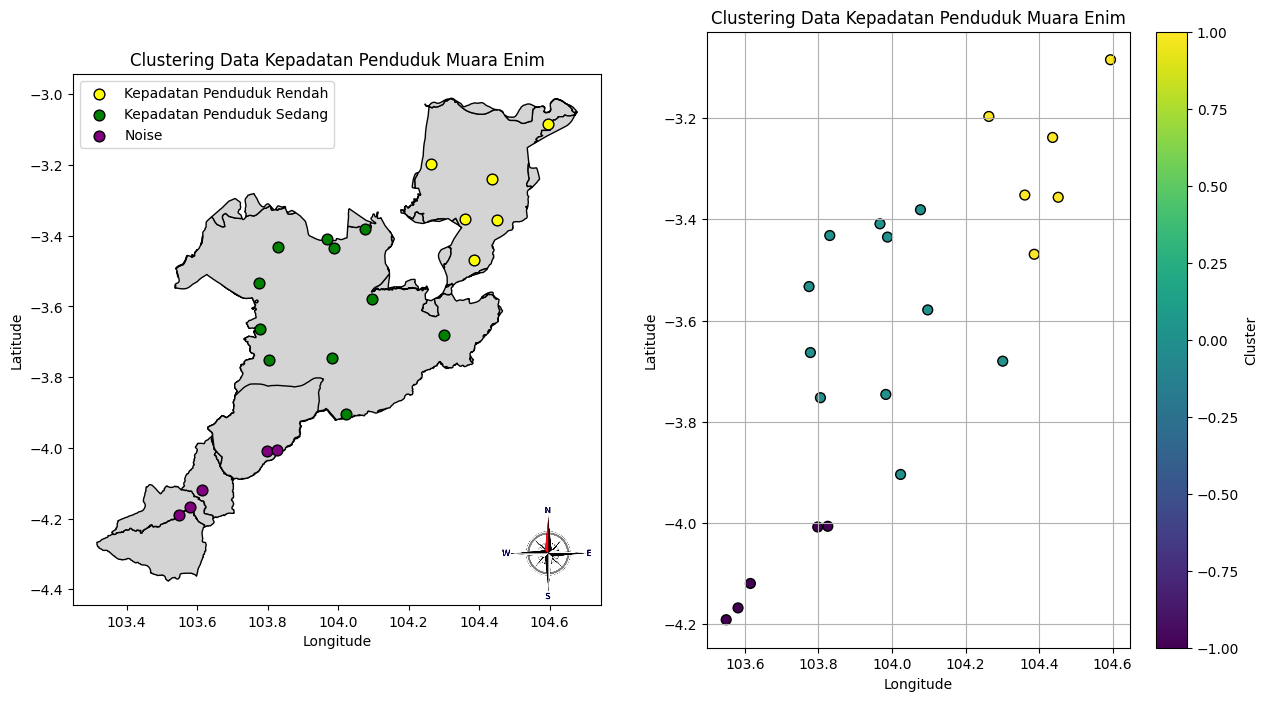

               Kecamatan                    Cluster
0           Belida Darat  Kepadatan Penduduk Rendah
1              Belimbing  Kepadatan Penduduk Sedang
2                Benakat  Kepadatan Penduduk Sedang
3   Empat Petulai Dangku  Kepadatan Penduduk Sedang
4              Gelumbang  Kepadatan Penduduk Rendah
5          Gunung Megang  Kepadatan Penduduk Sedang
6                Kelekar  Kepadatan Penduduk Rendah
7           Lawang Kidul  Kepadatan Penduduk Sedang
8                 Lembak  Kepadatan Penduduk Rendah
9                  Lubai  Kepadatan Penduduk Sedang
10             Lubai Ulu  Kepadatan Penduduk Sedang
11          Muara Belida  Kepadatan Penduduk Rendah
12            Muara Enim  Kepadatan Penduduk Sedang
13           Panang Enim                      Noise
14               Rambang  Kepadatan Penduduk Sedang
15          Rambang Niru  Kepadatan Penduduk Sedang
16    Semende Darat Laut                      Noise
17  Semende Darat Tengah                      Noise
18     Semen

In [ ]:
# Parameter
epsilon = 0.23  # Jarak maksimum antara dua titik agar dianggap sebagai bagian dari satu cluster
min_samples = 5  # Jumlah titik minimum untuk membentuk sebuah cluster
dbscan_cluster = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean').fit(gdf_population_density[['Longitude', 'Latitude']])

# Dapatkan label cluster
cluster_labels = dbscan_cluster.labels_

# Tentukan tiga kategori berdasarkan label cluster
# Misalnya, label -1 dianggap sebagai Noise, sedangkan label lainnya dianggap sebagai daerah dengan kepadatan sedang dan rendah
binary_labels = ['Noise' if label == -1 else ('Kepadatan Penduduk Sedang' if label == 0 else 'Kepadatan Penduduk Rendah') for label in cluster_labels]

# Tambahkan kolom binary_labels ke dalam DataFrame
gdf_population_density['Ternary_Labels'] = binary_labels

# Plot untuk visualisasi clustering
plt.figure(figsize=(15, 8))

# Plot peta
ax = plt.subplot(121)
gdf_boundary.plot(ax=ax, color='#D4D4D4',  edgecolor='black')
for category, group in gdf_population_density.groupby('Ternary_Labels'):
    group.plot(ax=ax, color='yellow' if category == 'Kepadatan Penduduk Rendah' else ('green' if category == 'Kepadatan Penduduk Sedang' else 'purple'), markersize=60, edgecolor='black', linewidth = 1, label=category)
plt.title('Clustering Data Kepadatan Penduduk Muara Enim')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Menambahkan gambar kompas pada plot peta
compass_image_path = '/content/drive/MyDrive/ADSP/Tubes/compass.png'
add_image(ax, compass_image_path, zoom=0.2, x=0.9, y=0.1)

# Plot clustering
plt.subplot(122)
plt.scatter(gdf_population_density['Longitude'], gdf_population_density['Latitude'], c=cluster_labels, cmap='viridis', s=50,edgecolor='black', linewidth = 1)
plt.title('Clustering Data Kepadatan Penduduk Muara Enim')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)

plt.show()


# Mengelompokkan data berdasarkan kecamatan dan label cluster
cluster_results = gdf_population_density.groupby(['Kecamatan', 'Ternary_Labels']).size().reset_index(name='Count')

# Membuat DataFrame dari hasil cluster
cluster_df = pd.DataFrame({
    'Kecamatan': cluster_results['Kecamatan'],
    'Cluster': cluster_results['Ternary_Labels'],
})

# Menampilkan DataFrame
print(cluster_df)

### Analisis

**Cluster 1**<br>
Cluster 1 terdiri dari kecamatan Gelumbang, Lembak, Sungai Rotan, Muara Belida, Kelekar, dan Belida Darat. Rata-rata kepadatan penduduk di Cluster 1 adalah 93.18 orang per kilometer persegi. Kecamatan-kecamatan ini memiliki kepadatan penduduk yang cukup tinggi, namun tidak setinggi kecamatan-kecamatan di Cluster 0. Hal ini mungkin disebabkan oleh letak geografis mereka yang relatif lebih jauh dari pusat kabupaten. Meskipun demikian, kecamatan-kecamatan ini masih memiliki akses yang memadai ke fasilitas dan infrastruktur dasar, yang memungkinkan penduduk untuk menjalani kehidupan sehari-hari dengan relatif nyaman.

**Cluster 0**<br>
Cluster 0 adalah kelompok dengan rata-rata kepadatan penduduk tertinggi, yaitu 132.70 orang per kilometer persegi. Kecamatan-kecamatan yang termasuk dalam Cluster 0 adalah yang terletak dekat dengan ibu kota kabupaten, Muara Enim. Kedekatan dengan pusat administrasi dan ekonomi ini memberikan keuntungan berupa akses yang lebih baik ke berbagai fasilitas publik seperti sekolah, rumah sakit, pasar, dan transportasi. Akses yang baik ini menarik lebih banyak penduduk untuk tinggal di daerah tersebut, sehingga menyebabkan kepadatan penduduk yang lebih tinggi. Faktor-faktor ini menunjukkan bahwa wilayah di sekitar ibu kota kabupaten menjadi pusat kegiatan ekonomi dan sosial yang signifikan.

**Noise**<br>
Kecamatan yang dikategorikan sebagai noise dalam analisis ini meliputi Semende Darat Laut, Semende Darat Ulu, Semende Darat Tengah, Tanjung Agung, dan Panang Enim. Rata-rata kepadatan penduduk di kecamatan-kecamatan ini adalah yang terendah, yaitu 52.89 orang per kilometer persegi. Kecamatan-kecamatan ini berada di daerah yang lebih terpencil dan memiliki akses yang lebih terbatas ke fasilitas dan infrastruktur dasar. Kondisi geografis dan keterbatasan akses ini menyebabkan distribusi penduduk yang lebih jarang dan tersebar, yang tidak memenuhi kriteria DBSCAN untuk membentuk cluster. Dalam konteks DBSCAN, noise berarti titik-titik ini tidak memiliki cukup tetangga dalam radius tertentu (parameter epsilon) untuk dianggap sebagai bagian dari cluster mana pun.

**Kesimpulan**<br>
Dari hasil ini, kita dapat melihat bahwa distribusi penduduk di Muara Enim sangat dipengaruhi oleh kedekatan dengan ibu kota kabupaten. Kecamatan-kecamatan yang lebih dekat dengan ibu kota kabupaten cenderung memiliki kepadatan penduduk yang lebih tinggi karena akses yang lebih baik ke fasilitas dan infrastruktur. Sebaliknya, kecamatan yang lebih terpencil memiliki kepadatan penduduk yang lebih rendah dan lebih mungkin dikategorikan sebagai noise oleh algoritma DBSCAN. Informasi ini penting untuk perencanaan infrastruktur, distribusi sumber daya, dan pengambilan keputusan lainnya oleh pemerintah daerah untuk meningkatkan kesejahteraan dan kualitas hidup penduduk di berbagai kecamatan.

# Evaluasi Hasil
### **Silhouette Score**

In [ ]:
# Evaluasi menggunakan Silhouette Score
silhouette_avg = silhouette_score(gdf_population_density[['Longitude', 'Latitude']], cluster_labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.4752891591071915


- Nilai Silhouette Score 0.4752891591071915 tergolong sedang.
- Nilai positif menunjukkan bahwa cluster memiliki kepadatan yang baik dan terpisahkan dengan baik.
- Kesimpulan: Silhouette Score 0.4752891591071915 menunjukkan bahwa clustering DBSCAN menghasilkan cluster yang cukup baik, namun masih ada ruang untuk peningkatan.

### **Davies-Bouldin Index**

In [ ]:
# Evaluasi menggunakan Davies-Bouldin Index
dbi_score = davies_bouldin_score(gdf_population_density[['Longitude', 'Latitude']], cluster_labels)
print("Davies-Bouldin Index:", dbi_score)

Davies-Bouldin Index: 0.6345303373989727


- Nilai DBI 0.6345303373989727 tergolong sedang.
- Nilai 0 menunjukkan cluster yang baik dan terpisahkan. Nilai 1 menunjukkan cluster yang buruk dan tidak terpisahkan. Nilai > 1 menunjukkan cluster yang sangat buruk.
- Kesimpulan: DBI 0.6345303373989727 menunjukkan bahwa clustering DBSCAN menghasilkan cluster yang cukup baik, namun masih ada ruang untuk peningkatan.

### **Dunn Index**

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances

def dunn_index(X, labels):
    """
    Menghitung Dunn Index untuk partisi tertentu dari data X dengan label cluster labels.
    """
    # Hitung matriks jarak pasangan antara titik
    distances = pairwise_distances(X)

    # Inisialisasi nilai Dunn Index
    min_intercluster_distance = np.inf
    max_intracluster_diameter = -np.inf

    # Loop melalui semua pasangan cluster
    unique_labels = np.unique(labels)
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            # Hitung jarak antara pusat cluster
            cluster_i_mean = np.mean(X[labels == unique_labels[i]], axis=0)
            cluster_j_mean = np.mean(X[labels == unique_labels[j]], axis=0)
            if np.any(np.isnan(cluster_i_mean)) or np.any(np.isnan(cluster_j_mean)):
                continue  # Skip if either cluster has no members
            intercluster_distance = np.linalg.norm(cluster_i_mean - cluster_j_mean)
            if intercluster_distance < min_intercluster_distance:
                min_intercluster_distance = intercluster_distance

    # Loop melalui semua cluster untuk menghitung diameter intracluster maksimum
    for i in range(len(unique_labels)):
        cluster_points = X[labels == unique_labels[i]]
        if len(cluster_points) > 1:
            cluster_diameter = np.max(pairwise_distances(cluster_points))
            if cluster_diameter > max_intracluster_diameter:
                max_intracluster_diameter = cluster_diameter

    # Dunn Index adalah rasio minimum jarak antar cluster dan maksimum diameter intracluster
    if max_intracluster_diameter == -np.inf:
        return np.nan  # Handle case where all clusters are empty
    else:
        dunn_index_value = min_intercluster_distance / max_intracluster_diameter
        return dunn_index_value


dunn_score = dunn_index(gdf_population_density[['Longitude', 'Latitude']].values, cluster_labels)
print("Dunn Index:", dunn_score)


Dunn Index: 0.9982235779455864


- Nilai Dunn Index 0.9982235779455864 tergolong tinggi.
- Nilai tinggi menunjukkan cluster yang baik dan terpisahkan.
- Kesimpulan: Dunn Index 0.9982235779455864 menunjukkan bahwa clustering DBSCAN menghasilkan cluster yang sangat baik dalam hal kepadatan dan pemisahan.


Secara keseluruhan, hasil evaluasi menunjukkan bahwa clustering DBSCAN menghasilkan cluster yang cukup baik dengan beberapa ruang untuk peningkatan. Silhouette Score dan DBI menunjukkan bahwa cluster memiliki kepadatan dan pemisahan yang cukup baik, namun masih ada potensi untuk optimasi. Di sisi lain, Dunn Index menunjukkan bahwa cluster memiliki kepadatan dan pemisahan yang sangat baik.